In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition

In [2]:
train = pd.read_csv('../data/raw/training_v2.csv')

In [3]:
datadict = pd.read_csv('../data/raw/WiDS Datathon 2020 Dictionary.csv')
continuous_cols = list(
    list(datadict[datadict['Data Type'] == 'integer']['Variable Name'].unique())
    + list(datadict[datadict['Data Type'] == 'numeric']['Variable Name'].unique())
)
categorical_cols = list(datadict[datadict['Data Type'] == 'string']['Variable Name'].unique())
binary_cols = list(datadict[datadict['Data Type'] == 'binary']['Variable Name'].unique())

target_col = 'hospital_death'
binary_cols.remove(target_col)


# fix datadict variable names
categorical_cols.remove('icu_admit_type')
continuous_cols.remove('pred')

In [4]:
train_fi = pd.read_csv('../reports/train-feature-importances.csv')
val_fi = pd.read_csv('../reports/val-feature-importances.csv')

In [187]:
top_categorical_cols = list()
i = 15
j = 0
while 0 < i:
    col = val_fi.loc[j, 'col_name']
    j = j + 1
    if col in categorical_cols + binary_cols:
        top_categorical_cols.append(col)
        i = i - 1
    if 300 < j:
        break
top_categorical_cols

['ventilated_apache',
 'apache_3j_diagnosis',
 'bmi',
 'hospital_admit_source',
 'apache_2_diagnosis',
 'icu_admit_source',
 'apache_2_bodysystem',
 'icu_type',
 'apache_3j_bodysystem',
 'solid_tumor_with_metastasis',
 'elective_surgery',
 'immunosuppression',
 'arf_apache',
 'intubated_apache',
 'cirrhosis']

In [73]:
top_continuous_cols = list()
i = 10
j = 0
while 0 < i:
    col = val_fi.loc[j, 'col_name']
    j = j + 1
    if col in continuous_cols:
        top_continuous_cols.append(col)
        i = i - 1
    if 100 < j:
        break
top_continuous_cols

['apache_4a_hospital_death_prob',
 'age',
 'apache_4a_icu_death_prob',
 'd1_spo2_min',
 'd1_bun_min',
 'd1_heartrate_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_wbc_min',
 'd1_temp_max']

In [68]:
import seaborn as sns

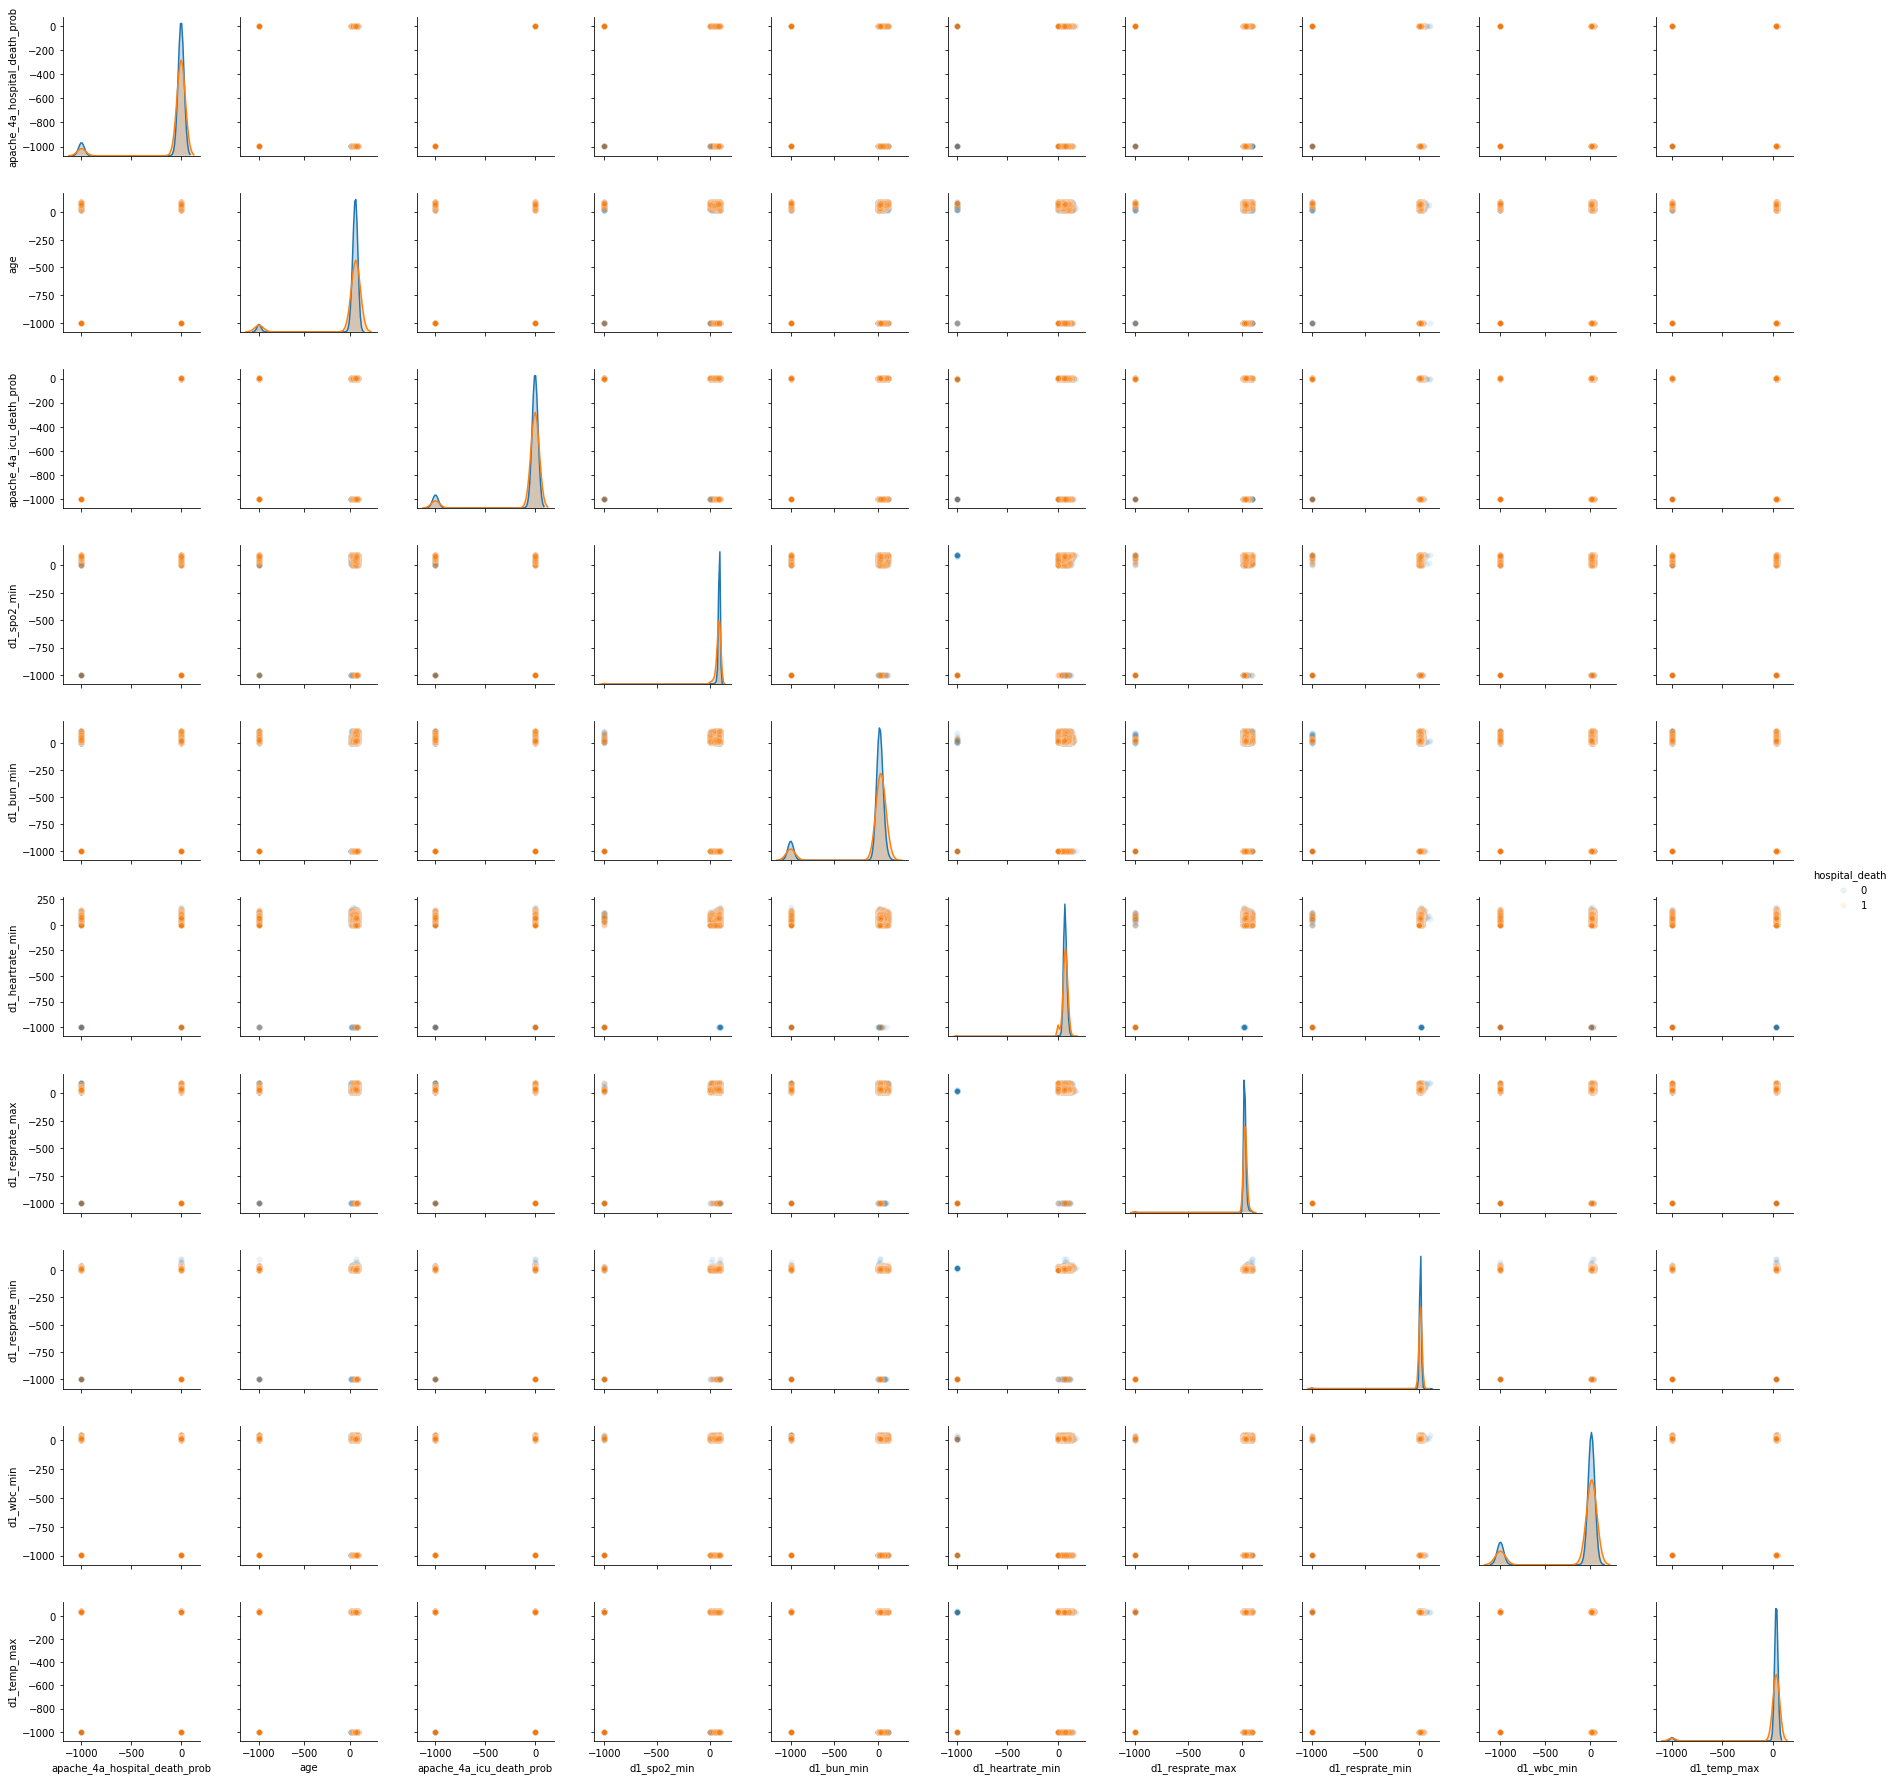

In [76]:
sns.pairplot(train.fillna(-999), vars=top_continuous_cols, hue=target_col, plot_kws={'alpha':0.1})

In [57]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(random_seed=42)

# Fit model
tmp = train.copy().dropna(subset=['apache_4a_hospital_death_prob']).fillna(-999)
tmp = tmp[tmp['apache_4a_hospital_death_prob'] >= 0]
X = tmp[tmp.columns.difference(['apache_4a_hospital_death_prob'])]
X[X.columns.difference(categorical_cols+binary_cols)] = X[X.columns.difference(categorical_cols+binary_cols)].astype('float32')
X[categorical_cols+binary_cols] = X[categorical_cols+binary_cols].astype('str')
y = tmp['apache_4a_hospital_death_prob'].astype('float32')
model.fit(X, y, cat_features=categorical_cols+binary_cols)

Learning rate set to 0.082239
0:	learn: 0.1538760	total: 93.3ms	remaining: 1m 33s
1:	learn: 0.1424913	total: 185ms	remaining: 1m 32s
2:	learn: 0.1318850	total: 359ms	remaining: 1m 59s
3:	learn: 0.1222578	total: 537ms	remaining: 2m 13s
4:	learn: 0.1136857	total: 643ms	remaining: 2m 7s
5:	learn: 0.1057424	total: 735ms	remaining: 2m 1s
6:	learn: 0.0982724	total: 822ms	remaining: 1m 56s
7:	learn: 0.0915813	total: 921ms	remaining: 1m 54s
8:	learn: 0.0854735	total: 1.01s	remaining: 1m 51s
9:	learn: 0.0797695	total: 1.1s	remaining: 1m 48s
10:	learn: 0.0746311	total: 1.22s	remaining: 1m 49s
11:	learn: 0.0698255	total: 1.31s	remaining: 1m 48s
12:	learn: 0.0654920	total: 1.4s	remaining: 1m 46s
13:	learn: 0.0614738	total: 1.5s	remaining: 1m 45s
14:	learn: 0.0579009	total: 1.58s	remaining: 1m 44s
15:	learn: 0.0545195	total: 1.68s	remaining: 1m 43s
16:	learn: 0.0514355	total: 1.78s	remaining: 1m 42s
17:	learn: 0.0487441	total: 1.86s	remaining: 1m 41s
18:	learn: 0.0462895	total: 1.95s	remaining: 1m 

In [58]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, model.predict(X))

6.716825797367258e-05

In [98]:
tmp2 = train[(0 > train['apache_4a_hospital_death_prob']) | (np.isnan(train['apache_4a_hospital_death_prob']))].copy().fillna(-999)
X2 = tmp2[tmp2.columns.difference(['apache_4a_hospital_death_prob'])]
X2[X2.columns.difference(categorical_cols+binary_cols)] = X2[X2.columns.difference(categorical_cols+binary_cols)].astype('float32')
X2[categorical_cols+binary_cols] = X2[categorical_cols+binary_cols].astype('str')
y2 = tmp2['apache_4a_hospital_death_prob'].astype('float32')

In [99]:
death_prob_preds = pd.DataFrame(model.predict(X2), columns=['apache_4a_hospital_death_prob'])

In [100]:
len(death_prob_preds)

8294

In [101]:
np.isnan(X2['hospital_death']).sum()

0

In [102]:
len(death_prob_preds), len(X2), len(pd.DataFrame(X2['hospital_death'], columns=['hospital_death']))

(8294, 8294, 8294)

In [112]:
samp = pd.concat(
    [
        death_prob_preds.reset_index(drop=True), 
        pd.DataFrame(X2['hospital_death'], columns=['hospital_death']).reset_index(drop=True)
    ], axis=1)

In [113]:
len(samp)

8294

In [114]:
samp = pd.concat([samp.reset_index(drop=True), pd.DataFrame(X2['encounter_id'], columns=['encounter_id']).reset_index(drop=True)], axis=1)

In [115]:
len(death_prob_preds)

8294

In [117]:
samp.corr()['hospital_death']

apache_4a_hospital_death_prob    0.360228
hospital_death                   1.000000
encounter_id                    -0.006508
Name: hospital_death, dtype: float64

In [120]:
samp.to_csv('../data/raw/regressive_death_prob.csv', index=False)

In [130]:
train['encounter_id'].dtypes

dtype('float64')

In [135]:
samp[samp['encounter_id']==97734.0]['apache_4a_hospital_death_prob']

0    0.127982
Name: apache_4a_hospital_death_prob, dtype: float64

In [141]:
np.any(np.isnan(mytrain['encounter_id']))

False

In [146]:
mytrain.loc[mytrain['encounter_id'].isin(samp['encounter_id']), 'apache_4a_hospital_death_prob'] = samp.loc[samp['encounter_id'].isin(mytrain['encounter_id']), 'apache_4a_hospital_death_prob'].values

In [147]:
mytrain.loc[mytrain['encounter_id'].isin(samp['encounter_id']), 'apache_4a_hospital_death_prob']

4        0.127982
62       0.131416
67       0.035460
89       0.430382
127      0.145487
176      0.172647
212      0.180252
236      0.024525
267      0.128758
291      0.134537
296      0.124050
304      0.150903
321      0.130014
325      0.038046
354      0.151847
365      0.062149
371      0.068586
381      0.184680
395      0.026176
396      0.267617
408      0.119036
424      0.061977
473      0.183754
478      0.065636
481      0.204362
489      0.029287
524      0.581821
527      0.353521
532      0.016419
536      0.091404
           ...   
73892    0.018290
73893    0.060260
73894    0.044036
73895    0.045197
73896    0.146043
73897   -0.005477
73898    0.164620
73899    0.014212
73900    0.040570
73906    0.193122
73927    0.047948
73939    0.002565
73941    0.185427
73942    0.172457
73945   -0.002541
73947    0.014986
73949    0.187881
73959    0.041719
73981    0.095434
74048    0.031592
74059    0.163442
74061    0.022641
74066    0.107282
74067    0.051956
74093    0

In [143]:
mytrain = train.copy()
mytrain['encounter_id'] = mytrain['encounter_id'].astype('float32')
mytrain.apply(lambda row: samp[samp['encounter_id']==row['encounter_id']]['apache_4a_hospital_death_prob'].values if row['encounter_id'] in samp['encounter_id'] else row['apache_4a_hospital_death_prob'], axis=1)

0                           []
1                         0.09
2                         0.03
3                           []
4                          NaN
5                           []
6                         0.09
7                         0.01
8                         0.07
9                         0.01
10                        0.09
11                        0.18
12                         0.2
13                        0.01
14                        0.01
15                        0.01
16                        0.02
17                        0.06
18                        0.11
19                          []
20                        0.05
21                          []
22                        0.14
23                        0.02
24                        0.04
25                           0
26                        0.09
27                        0.07
28                        0.03
29                        0.04
                 ...          
74093    [0.20884889481490404]
74094   

In [118]:
samp.head()

,apache_4a_hospital_death_prob,hospital_death,encounter_id
0,0.127982,1.0,97734.0
1,0.131416,0.0,21436.0
2,0.035460,0.0,19946.0
3,0.430382,0.0,93496.0
4,0.145487,0.0,9716.0


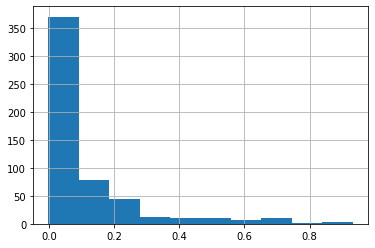

In [71]:
samp[samp['hospital_death']==1]['apache_4a_hospital_death_prob'].hist()

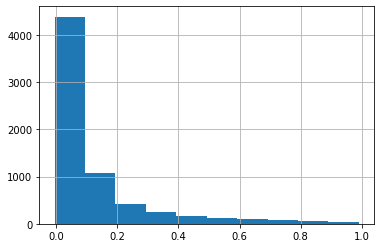

In [72]:
samp[samp['hospital_death']==0]['apache_4a_hospital_death_prob'].hist()

ValueError: array must not contain infs or NaNs

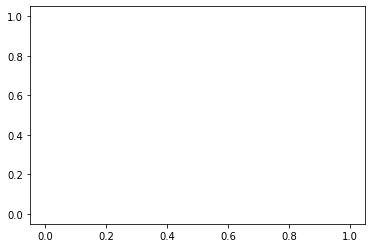

In [48]:

#sns.pairplot(samp, vars=top_continuous_cols, hue=target_col, plot_kws={'alpha':0.1})
sns.distplot(samp[samp['hospital_death']==1]['apache_4a_hospital_death_prob'], hist=False, rug=True)
sns.distplot(samp[samp['hospital_death']==0]['apache_4a_hospital_death_prob'], hist=False, rug=True)
plt.show()

In [22]:
[x for x in train.columns if 'prob' in x]

['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']

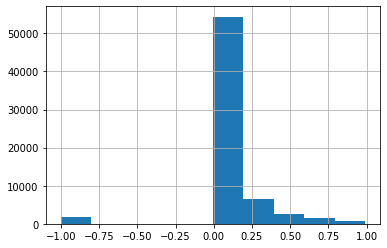

In [24]:
train['apache_4a_hospital_death_prob'].hist()

In [29]:
train[0 > train['apache_4a_hospital_death_prob']][target_col].value_counts()

0    1713
1     181
Name: hospital_death, dtype: int64

In [103]:
len(train[np.isnan(train['d1_heartrate_min']) & train[target_col] == 0])

91693

In [120]:
np.sum(np.isnan(train['d1_heartrate_min']))

145

In [119]:
np.sum(~np.isnan(train['d1_temp_max']))

89389

In [133]:
train[np.isnan(train['d1_heartrate_min']) & np.isnan(train['d1_temp_max'])][target_col].sum(), train[np.isnan(train['d1_heartrate_min']) & np.isnan(train['d1_temp_max'])][target_col].count()

(19, 98)

In [127]:
# train[np.isnan(train['d1_heartrate_min']) & ~np.isnan(train['d1_temp_max'])][['d1_heartrate_min', 'd1_temp_max', target_col]]

In [5]:
from pathlib import Path
input_filepath = '../data/interim/'
output_filepath = '../data/processed/'
# data
TRAIN_CSV = Path.cwd().joinpath(input_filepath).joinpath('train.csv')
VAL_CSV = Path.cwd().joinpath(input_filepath).joinpath('val.csv')
TEST_CSV = Path.cwd().joinpath(input_filepath).joinpath('test.csv')
PREDS_CSV = Path.cwd().joinpath(input_filepath).joinpath('preds.csv')

train = pd.read_csv(TRAIN_CSV)
val = pd.read_csv(VAL_CSV)
test = pd.read_csv(TEST_CSV)
preds = pd.read_csv(PREDS_CSV)

In [175]:
preds[continuous_cols].astype('float32')

,encounter_id,hospital_id,patient_id,icu_id,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache,age,height,pre_icu_los_days,...,tell_d1_mbp_min_bun_apache,tell_d1_mbp_min_d1_sysbp_noninvasive_min,tell_d1_mbp_min_gcs_verbal_apache,tell_d1_mbp_min_resprate_apache,tell_bun_apache_d1_sysbp_noninvasive_min,tell_bun_apache_gcs_verbal_apache,tell_bun_apache_resprate_apache,tell_d1_sysbp_noninvasive_min_gcs_verbal_apache,tell_d1_sysbp_noninvasive_min_resprate_apache,tell_gcs_verbal_apache_resprate_apache
0,2.0,7.0,127112.0,1105.0,2.0,5.0,1.0,56.0,180.300003,0.104167,...,0.060571,0.189661,0.146832,0.050131,0.047070,0.132690,0.076888,0.184686,0.042440,0.243114
1,5.0,178.0,130737.0,1043.0,4.0,6.0,4.0,NaN,145.000000,0.230556,...,0.096282,0.144960,0.112381,0.134803,0.079481,0.096066,0.129972,0.127272,0.118344,0.147654
2,7.0,86.0,101458.0,1035.0,2.0,5.0,1.0,66.0,170.199997,0.140972,...,0.015372,0.128939,0.159414,0.046870,0.055112,0.186965,0.163368,0.217662,0.000000,0.242626
3,8.0,163.0,48067.0,1078.0,4.0,6.0,1.0,64.0,182.800003,0.002083,...,0.173422,0.187446,0.274378,0.307241,0.186346,0.241947,0.104789,0.336692,0.259634,0.237092
4,10.0,59.0,25865.0,1012.0,1.0,4.0,1.0,56.0,NaN,0.004861,...,0.506667,0.000000,0.470801,0.220476,0.214658,0.112789,0.011231,0.381293,0.341414,0.243114
5,16.0,175.0,75049.0,1071.0,3.0,5.0,1.0,55.0,180.000000,0.332639,...,0.055941,0.098335,0.231878,0.156413,0.474359,0.287184,0.245605,0.266968,0.347967,0.294688
6,18.0,172.0,89318.0,966.0,4.0,5.0,4.0,79.0,170.199997,0.199306,...,0.137786,0.000000,0.083350,0.040293,0.000000,0.135952,0.161289,0.099572,0.048653,0.047347
7,19.0,162.0,101385.0,971.0,4.0,6.0,5.0,64.0,187.960007,0.022222,...,0.050000,0.000000,0.025993,0.000000,0.300000,0.126457,0.600000,0.019338,0.000000,0.012362
8,23.0,28.0,90017.0,998.0,4.0,6.0,5.0,58.0,157.500000,1.292361,...,0.000000,0.090707,0.073452,0.191292,0.115000,0.006969,0.016188,0.170778,0.075278,0.035370
9,25.0,175.0,120402.0,1063.0,4.0,6.0,5.0,64.0,165.000000,18.825695,...,0.042478,0.000000,0.034620,0.000000,0.000000,0.006969,0.015409,0.000000,0.000000,0.034694


In [157]:
pd.DataFrame(rfr.predict_proba(train[['d1_heartrate_min','d1_temp_max']].fillna(-999))[:,1], columns=['a']).shape

(91713, 1)

In [149]:
rfr.predict_proba(train[np.isnan(train['d1_heartrate_min']) & ~np.isnan(train['d1_temp_max'])][['d1_heartrate_min','d1_temp_max']].fillna(-999))[:,1]

array([0.        , 0.        , 0.        , 0.31166667, 0.        ,
       0.        , 0.31166667, 0.31166667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1       ,
       0.        , 0.        , 0.        , 0.15333333, 0.        ,
       0.        , 0.        , 0.02      , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.09      , 0.        ,
       0.        , 0.        ])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x171c4fe10>,
      dtype=object)

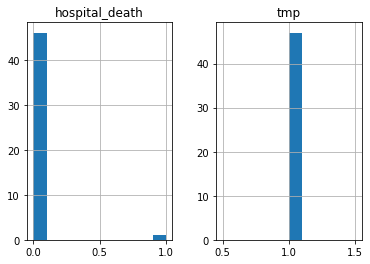

In [141]:
train['tmp'] = np.isnan(train['d1_heartrate_min']) & ~np.isnan(train['d1_temp_max'])
train['tmp'] = train['tmp'].astype('float32')
train[np.isnan(train['d1_heartrate_min']) & ~np.isnan(train['d1_temp_max'])][['tmp', target_col]].hist()

In [74]:
top_continuous_cols_2 = list()
i = 10
j = 0
while 0 < i:
    col = val_fi.loc[j + 10, 'col_name']
    j = j + 1
    if col in continuous_cols:
        top_continuous_cols_2.append(col)
        i = i - 1
    if 100 < j:
        break
top_continuous_cols_2

['d1_wbc_min',
 'd1_temp_max',
 'd1_heartrate_max',
 'd1_temp_min',
 'd1_sodium_max',
 'd1_lactate_min',
 'd1_bun_max',
 'd1_glucose_min',
 'd1_platelets_min',
 'd1_arterial_ph_min']

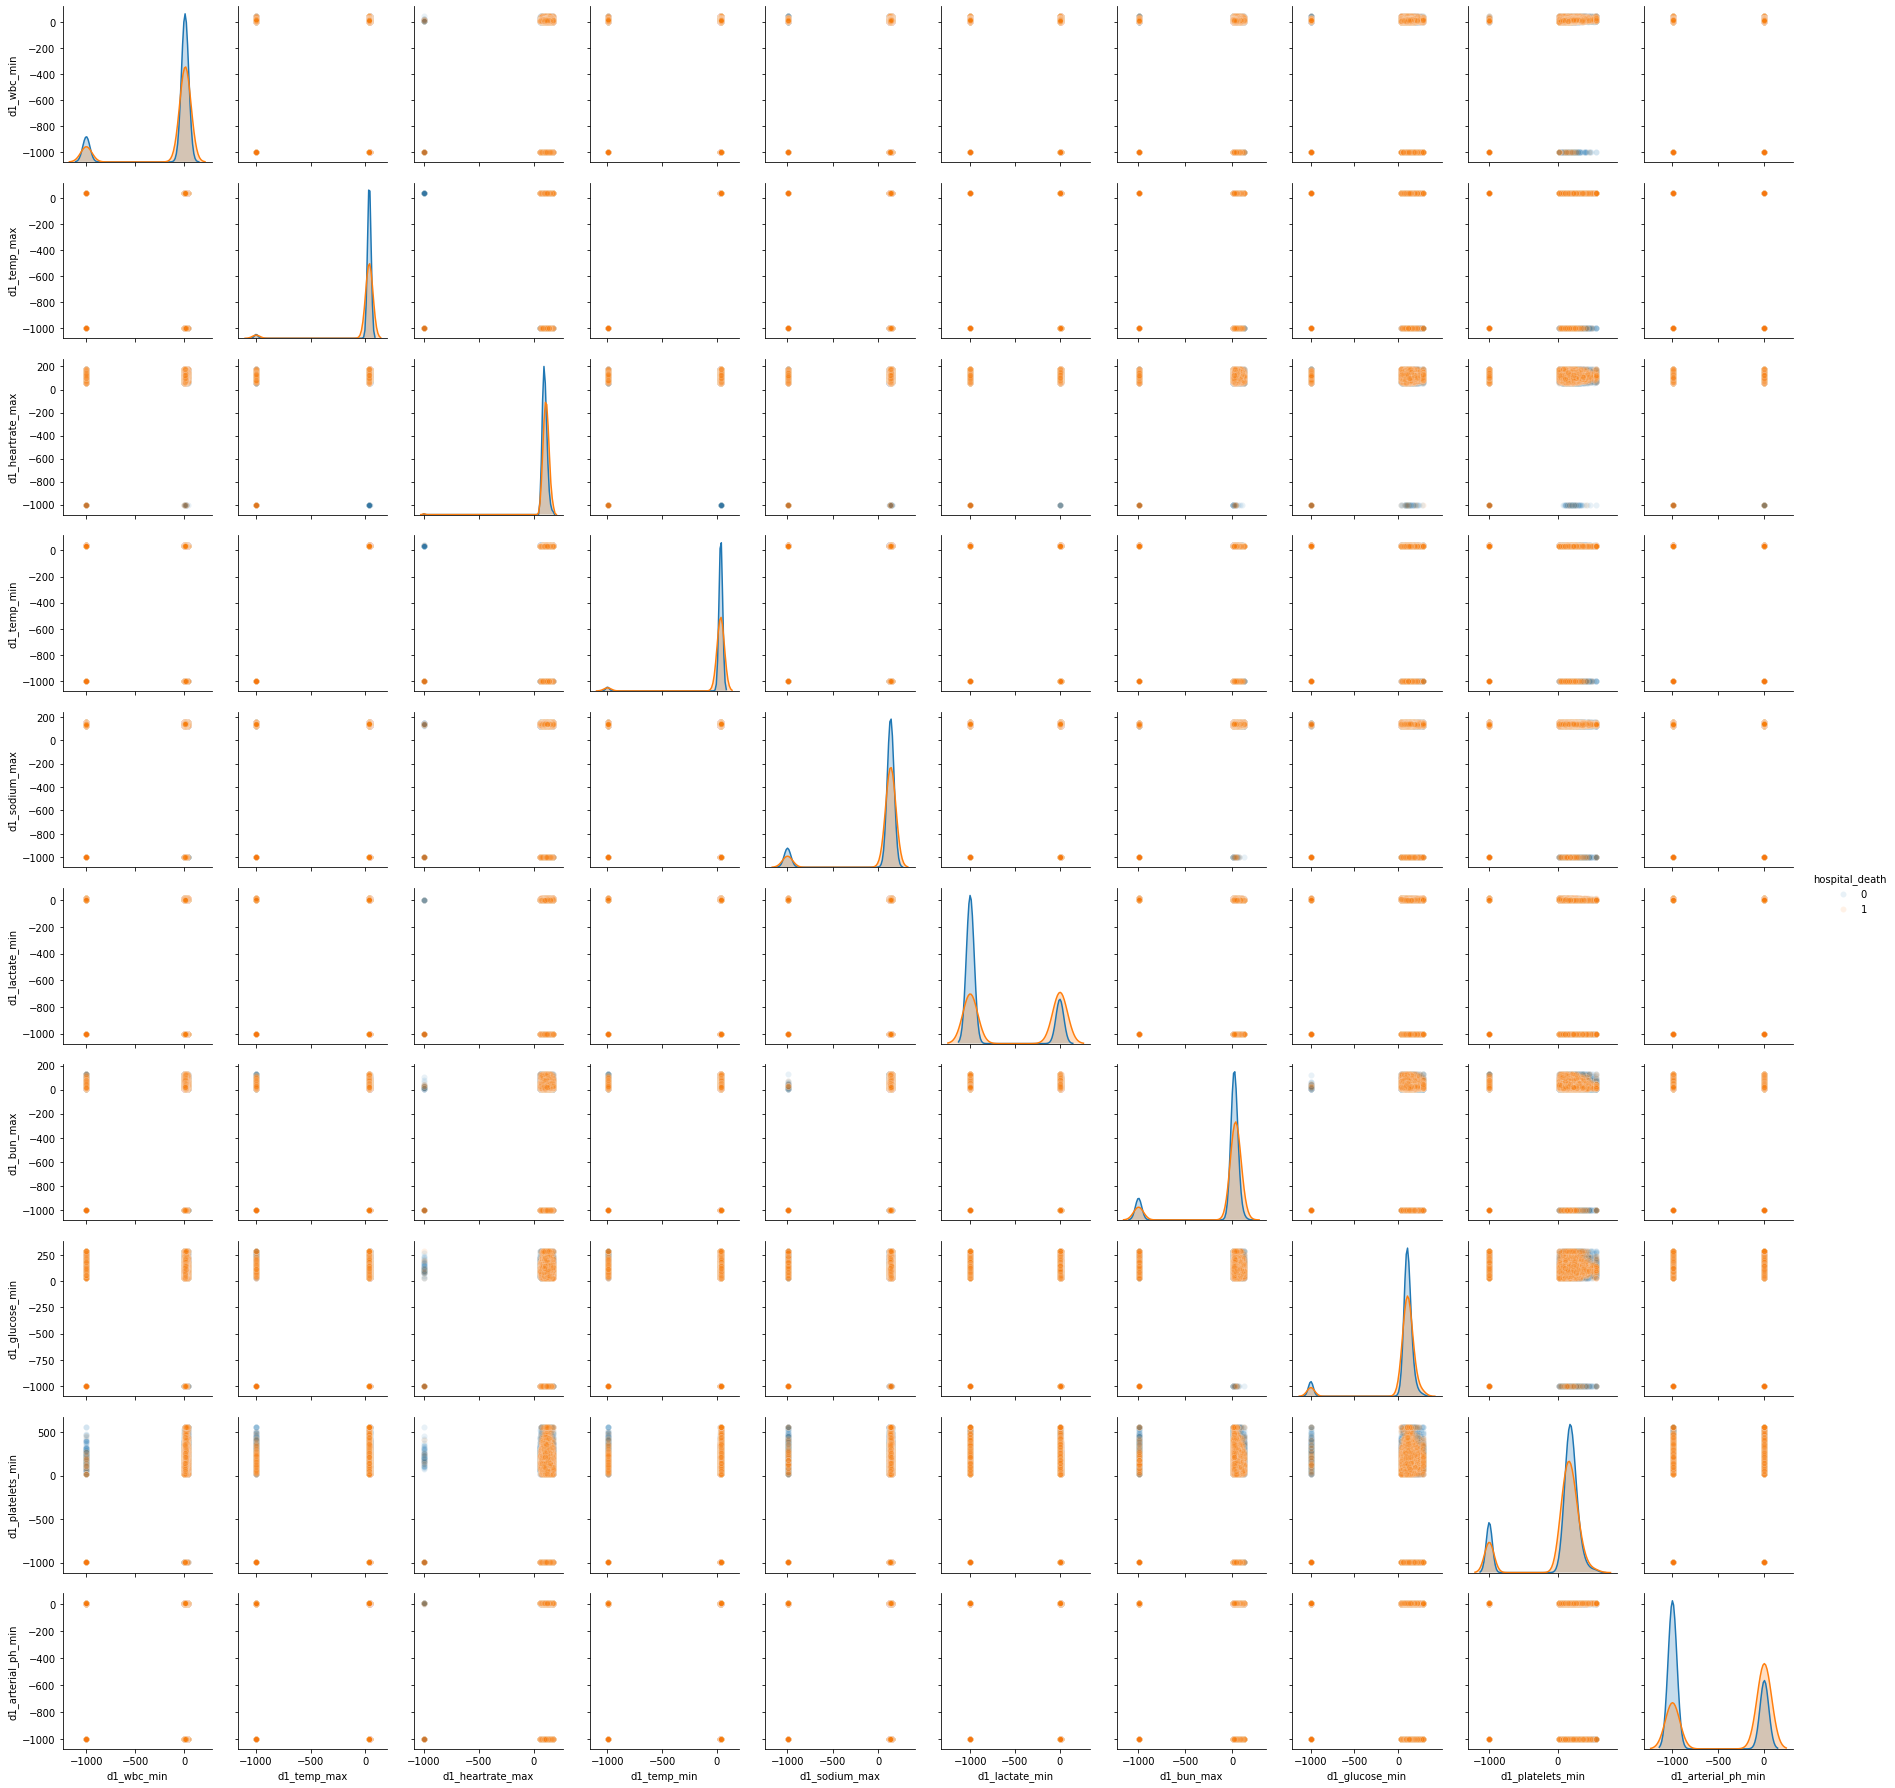

In [75]:
sns.pairplot(train.fillna(-999), vars=top_continuous_cols_2, hue=target_col, plot_kws={'alpha':0.1})

In [20]:
top_continuous_cols = [
        ('d1_glucose_min', 'd1_platelets_min'),
        ('d1_bun_max', 'd1_platelets_min')
    ]

In [11]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
rfr = RandomForestClassifier(random_state=0)
        
cols = ['d1_glucose_min', 'd1_platelets_min']
#feature_name = f'tell_{feature_a}_{feature_b}'
data = train[cols].fillna(-999)
rfr.fit(data, train[target_col])

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [12]:
train[target_col].values

array([0, 0, 0, ..., 0, 0, 0])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: The following kwargs were not used by contour: 'clim'


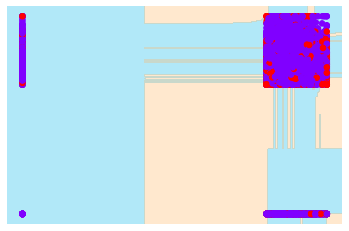

In [18]:
#rfr =RandomForestClassifier(random_state=0, class_weight={0:0.1,1:10})
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
model = KNeighborsClassifier(n_neighbors=5, weights='distance')
#model = GaussianNB(weights='balanced')
visualize_classifier(model, data.to_numpy(), train[target_col].to_numpy())

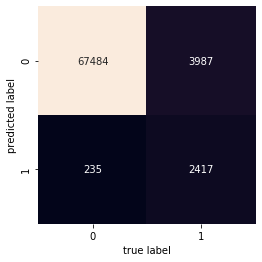

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(train[target_col], model.predict(data))
sns.heatmap(mat.T, squarae=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [202]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

In [7]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

In [154]:
xx = [
        'apache_4a_hospital_death_prob',
        'age',
        'apache_4a_icu_death_prob',
        'd1_spo2_min',
        'd1_bun_min',
        'd1_heartrate_min',
        'd1_resprate_max',
        'd1_resprate_min',
        'd1_wbc_min',
        'd1_temp_max',
        'd1_heartrate_max',
        'd1_temp_min',
        'd1_sodium_max',
        'd1_lactate_min',
        'd1_bun_max',
        'd1_glucose_min',
        'd1_platelets_min',
        'd1_arterial_ph_min',
        'd1_arterial_ph_min',
        'd1_mbp_noninvasive_min',
        'pre_icu_los_days',
        'd1_sysbp_min',
        'wbc_apache',
        'd1_mbp_min',
        'bun_apache',
        'd1_sysbp_noninvasive_min',
        'gcs_verbal_apache',
        'resprate_apache'
    ]
len(list(combinations(xx, 2)))

378

In [77]:
top_continuous_cols_3 = list()
i = 10
j = 0
while 0 < i:
    col = val_fi.loc[j + 20, 'col_name']
    j = j + 1
    if col in continuous_cols:
        top_continuous_cols_3.append(col)
        i = i - 1
    if 100 < j:
        break
top_continuous_cols_3

['d1_arterial_ph_min',
 'd1_mbp_noninvasive_min',
 'pre_icu_los_days',
 'd1_sysbp_min',
 'wbc_apache',
 'd1_mbp_min',
 'bun_apache',
 'd1_sysbp_noninvasive_min',
 'gcs_verbal_apache',
 'resprate_apache']

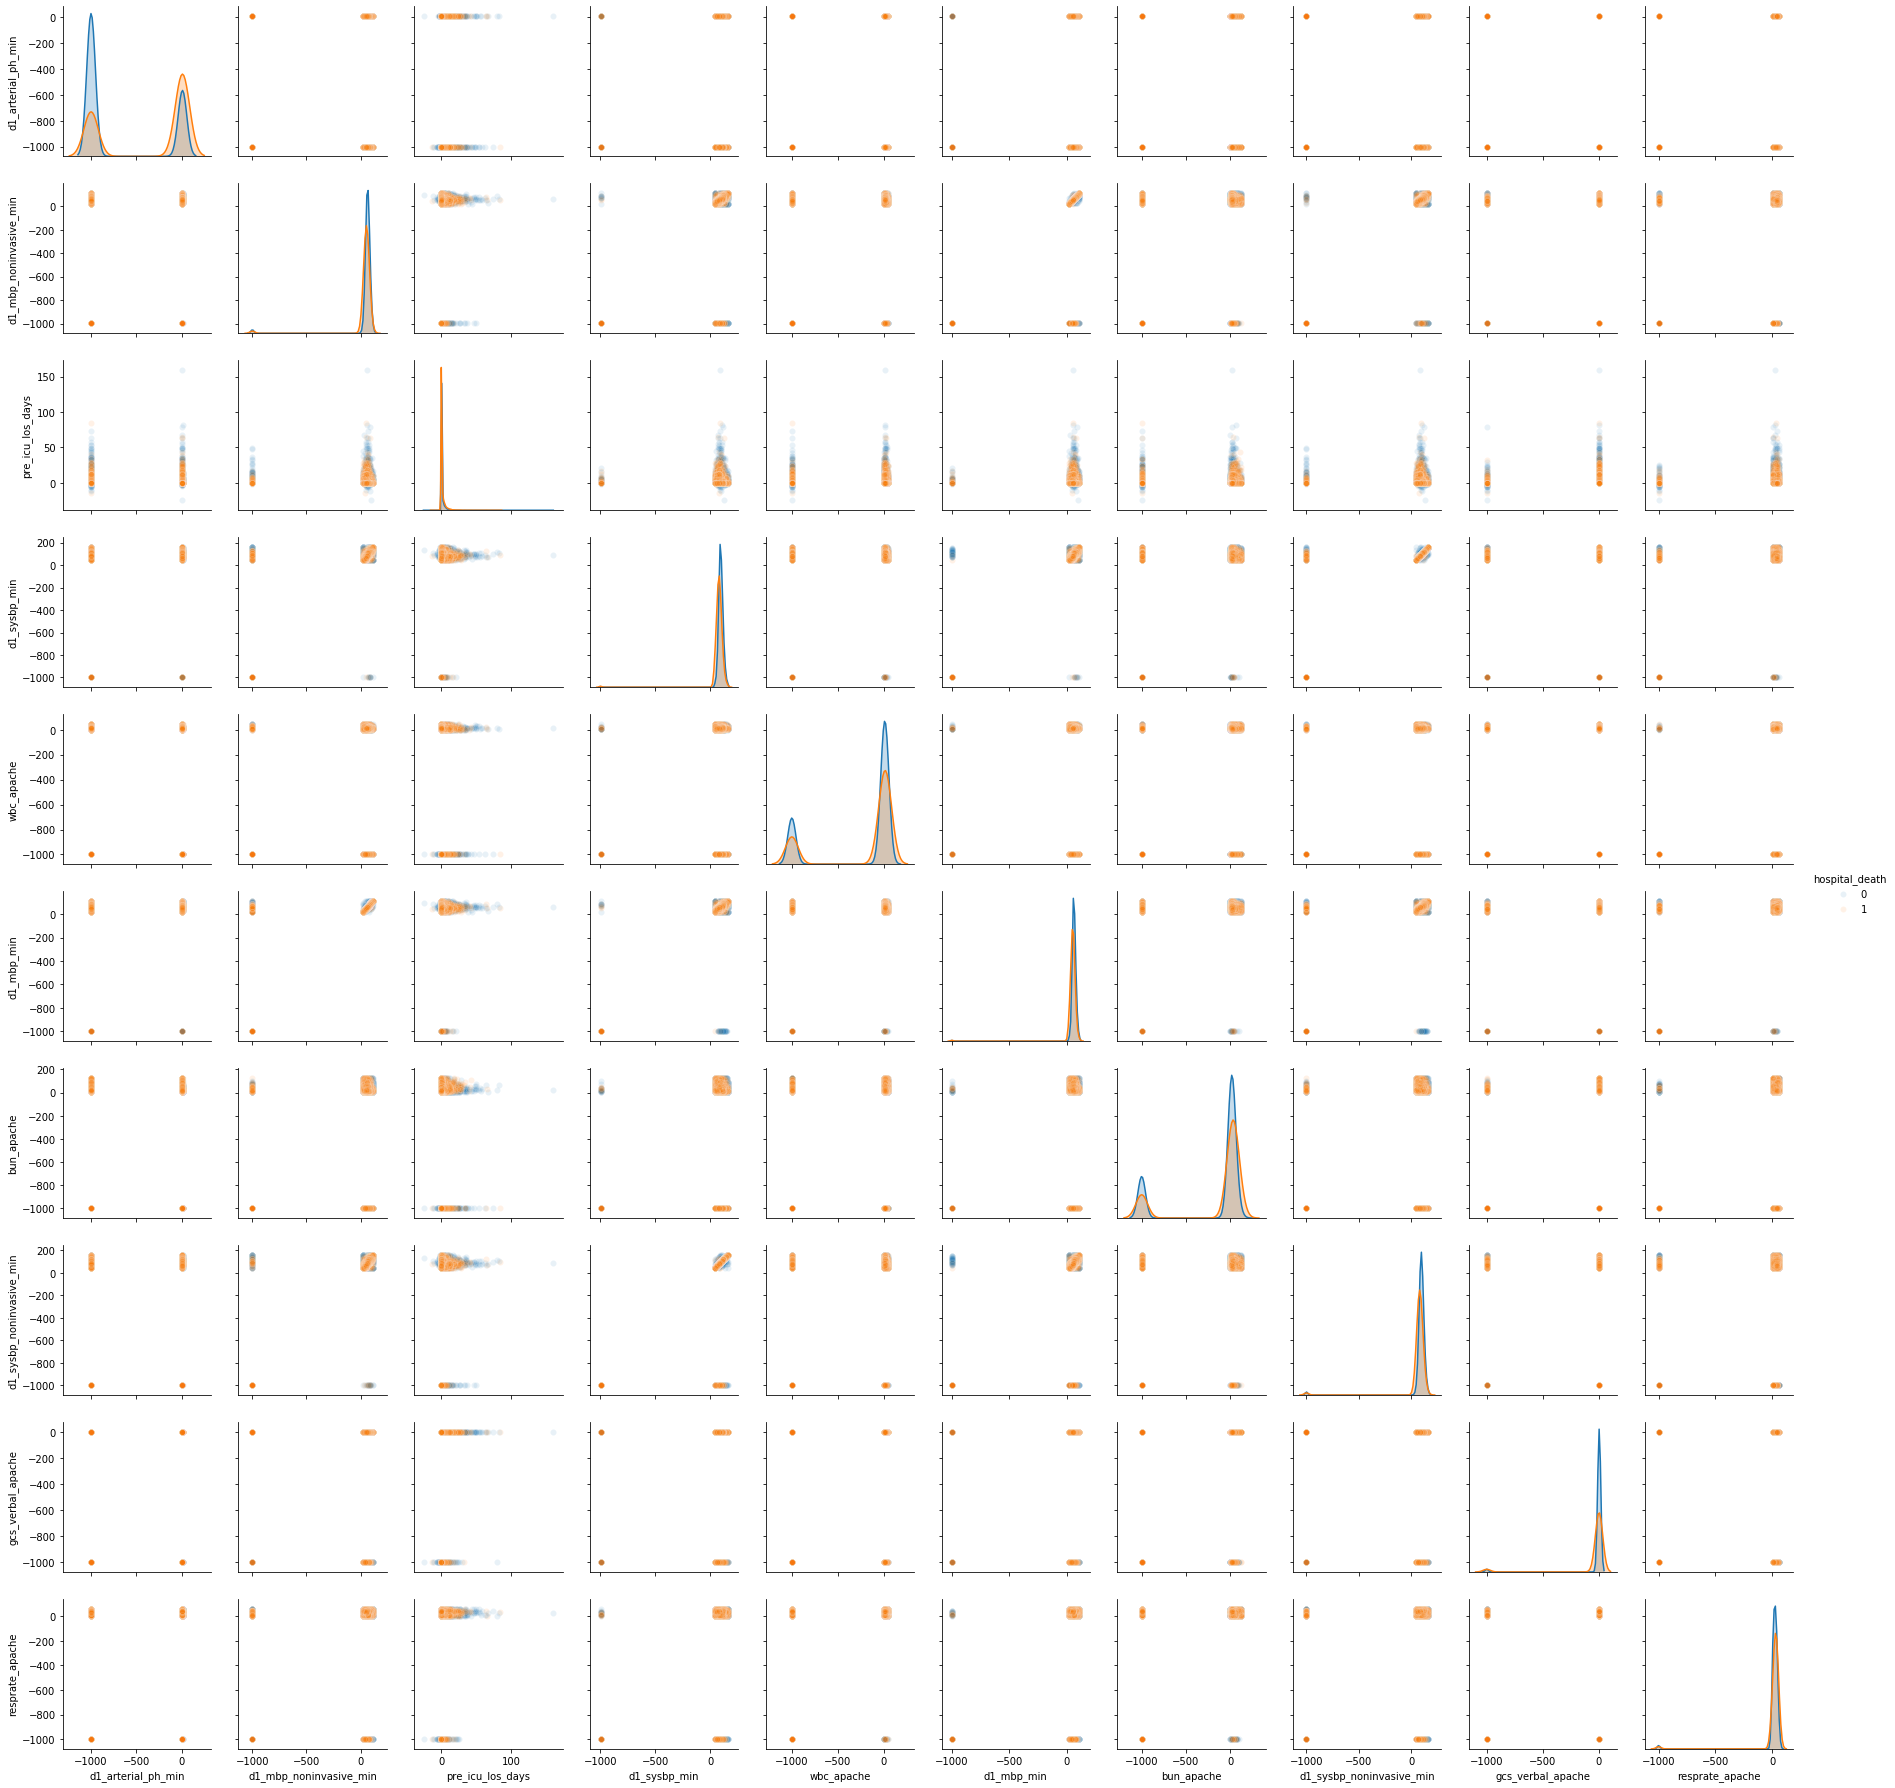

In [78]:
sns.pairplot(train.fillna(-999), vars=top_continuous_cols_3, hue=target_col, plot_kws={'alpha':0.1})

In [54]:
mask = train[target_col] == True
positive_class = train[mask][continuous_cols]
negative_class = train[~mask][continuous_cols]

In [55]:
len(continuous_cols)

159

In [48]:
pca = decomposition.PCA(n_components=2)

clustering_cols = [
    'apache_4a_hospital_death_prob',
    'age',
    'ventilated_apache',
    'd1_spo2_min',
    'gcs_motor_apache',
    'd1_bun_max',
    'd1_heartrate_min',
    'd1_resprate_max',
    'apache_3j_diagnosis',
    'd1_heartrate_max',
    'bmi',
    'd1_resprate_max'
]
clustering_cols = continuous_cols
sample = train[clustering_cols].astype('float32')
for col in sample.columns:
    mu = np.mean(sample[col].values)
    if np.isnan(mu) or mu == 0 or None is mu:
        mu = 0
    sample[col] = sample[col].fillna(mu)
pca.fit(sample)
X = pca.transform(sample)

In [49]:
X

array([[ -49.56693271,  -15.6819422 ],
       [-348.49361966,   -9.89272819],
       [ 151.61045569,    5.68788171],
       ...,
       [ 150.43784572,  -54.95644486],
       [-348.43319177,   15.70583555],
       [ 857.49011853,    2.57701321]])

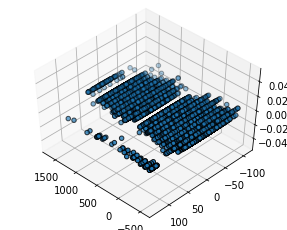

In [50]:
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
ax.scatter(X[:, 0], X[:, 1],   cmap=plt.cm.nipy_spectral,
           edgecolor='k')
plt.show()

In [24]:
from sklearn.cluster import KMeans

In [27]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [28]:
kmeans.labels_

array([2, 0, 2, ..., 2, 0, 1], dtype=int32)

In [29]:
len(kmeans.labels_), len(train)

(91713, 91713)

In [32]:
pd.DataFrame(kmeans.labels_, columns=['cluster_label']).head()

,cluster_label
0,2
1,0
2,2
3,1
4,2


In [40]:
kmeans.predict(X)

array([2, 0, 2, ..., 2, 0, 1], dtype=int32)